In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader,Dataset
import re
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install gensim==4.0.1


     |████████████████████████████████| 23.9MB 127kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import gensim

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
word2vec_model=gensim.models.keyedvectors.load_word2vec_format('drive/MyDrive/Comment/wiki_word2vec_50.bin',binary=True)

words=[]
with open('drive/MyDrive/Comment/train.txt','r',encoding='UTF-8') as f:
    lines=f.readlines()
    for line in lines:
        line_words = re.split(r'[\s]', line)[1:-1]
        for w in line_words:
                words.append(w)

words=sorted(set(words))#words是新的词表 ,需要word2ix,ix2word,和ix2vector
word2ix={w:i+1 for i,w in enumerate(words)}
ix2word={i+1:w for i ,w in enumerate(words)}
word2ix['UNK']=0
ix2word[0]='UNK'

In [5]:
class MyComment2(Dataset):
    def __init__(self,path,word2ix):
        self.word2ix=word2ix
        self.labels=[]
        self.comments=[]
        with open(path,'r',encoding='UTF-8') as f:
            lines=f.readlines()
        for line in lines:
            line=re.split(r'[\s]',line)
            self.labels.append(int(line[0]))
            comment=line[1:-1]
            comment_dig=[]
            for i in comment:
                try:
                    comment_dig.append(word2ix[i])
                except KeyError:
                    comment_dig.append(0)
            self.comments.append(torch.tensor(comment_dig,dtype=torch.int64))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,num):
        return self.comments[num],self.labels[num]
    
#精加工，返回的是补齐的tensor格式，comment和lengths进lstm
def mycollate_fn(batch):
    batch.sort(key=lambda x:len(x[0]),reverse=True)
    lengths=[len(i[0]) for i in batch]
    labels=torch.tensor([i[1] for i in batch],dtype=torch.long)
    comment=[i[0] for i in batch]
    comment=pad_sequence(comment,batch_first=True,padding_value=0)
    return comment,lengths,labels

    
    
train_ds=MyComment2(path='drive/MyDrive/Comment/train.txt',word2ix=word2ix)
train_loader=DataLoader(train_ds,40,shuffle=True,collate_fn=mycollate_fn)

val_ds=MyComment2(path='drive/MyDrive/Comment/validation.txt',word2ix=word2ix)
val_loader=DataLoader(val_ds,40,shuffle=True,collate_fn=mycollate_fn)
test_ds=MyComment2(path='drive/MyDrive/Comment/test.txt',word2ix=word2ix)
test_loader=DataLoader(test_ds,40,shuffle=True,collate_fn=mycollate_fn)


In [6]:
print(len(word2ix))
#ix-->WORD-->word2vec_model.key_to_index[...]-->model.getvector(.)
#没有的词初始化为0向量
my_weight=[]
for i in range(len(word2ix)):
    word=ix2word[i]
    try:
        index=word2vec_model.key_to_index[word]
        my_weight.append(torch.tensor(word2vec_model.get_vector(index)))
    except KeyError:
        my_weight.append(torch.zeros(50))
my_weight=torch.stack(my_weight)

53338


In [42]:
def Confuse(outputs, labels):
    #测试阶段使用，训练完成后在test.txt上运行
    #（positive和negative是指预测）（Ture和False是指判断的正误）
    _, preds = torch.max(outputs, dim=1)
    confuse_matrix=np.zeros((2,2))
    for i in range(len(preds)):
        confuse_matrix[preds[i].item(),labels[i].item()]+=1
    #（0，0）：TN，（0，1）：pred=0，label=1 FN
    #（1，0）：pred=1，label=0，FP，（1，1）：TP
    return confuse_matrix


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FeelingCatcher(nn.Module):
            
    def __init__(self,hid_dim,n_layers, renew ,length_change, who):
        super(FeelingCatcher,self).__init__()
        
        if who!='hidden'and who!='output' and who!='output_last':
            print('who是指用谁进行判断，请在hidden，output，output_last中做选择')
            return -1
        
        self.embedding=nn.Embedding.from_pretrained(my_weight)
        self.embedding.requires_grad_=renew  #决定是否学习新的词向量
        
        self.lstm=nn.LSTM(50,hid_dim,n_layers,batch_first=True,dropout=0.2)
        #lstm——hidden——【batchsize，hid_dim,n_layers】
        #lstm----outputs----[batchsize,seq_len,hid_dim]
        
        self.dropout=nn.Dropout(0.5)
        self.fc1=nn.Linear(hid_dim,256)
        self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(64,2)
        
        self.length_change=length_change# 是否接受不定长输入
        self.who=who #选谁判断

        
    def forward(self,comments,lengths):
        out=self.embedding(comments)
        
        if self.length_change:
            out=pack_padded_sequence(out,lengths,batch_first=True)
            out,hidden=self.lstm(out)  #hidden[n_layers,batchsize,,hidden]
            out=pad_packed_sequence(out,batch_first=True)[0] #[batch,seq_len,hidden_dim]
        else:
            out,hidden=self.lstm(out)
            
        if self.who=='output_last':
            out=out[:,-1,:]   #[batch,hidden_dim]

        if self.who=='output':
            out=torch.sum(out,dim=1)/out.shape[1]

        if self.who=='hidden':
            out=hidden[1][-1,:,:]
            
            
        out=self.dropout(torch.tanh(self.fc1(out)))
        out=self.dropout(torch.tanh(self.fc2(out)))

        out=self.fc3(out)
        
        return out   #[batch,2]
    
    
    def step(self, batch, device):  #返回一个batch的loss和acc
        comments, lengths, labels = batch
        comments=comments.to(device)
        labels=labels.to(device)
        
        out = self(comments,lengths)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'loss': loss, 'acc': acc}
    
        
    def evaluate(self, loader,device):     #打包评价这轮valloader中loss和acc的平均值
        outputs = [self.step(batch,device) for batch in loader]
        losses = [x['loss'] for x in outputs]
        losses = torch.stack(losses).mean()
        accs = [x['acc'] for x in outputs]
        accs = torch.stack(accs).mean()
        return {'loss': losses.item(), 'acc': accs.item()}

    
    def epoch_end(self, epoch, train_loss,result):  #打印训练，测试上的loss，acc
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, train_loss, result['loss'], result['acc']))

def test(model,loader):
  model.eval()
  with torch.no_grad():
    loss=0.0
    confuse=np.zeros((2,2))
    for batch in loader:
        comments,lengths,labels=batch
        comments=comments.to(device)
        labels=labels.to(device)
        out=model(comments,lengths)
        loss+=F.cross_entropy(out,labels)
        confuse+=Confuse(out, labels)
    return loss, confuse

def eva_test(confuse):
    #（0，0）：TN，（0，1）：pred=0，label=1 FN
    #（1，0）：pred=1，label=0，FP，（1，1）：TP
    TP=confuse[1,1]
    TN=confuse[0,0]
    FP=confuse[1,0]
    FN=confuse[0,1]
    precise=TP/(FP+TP)
    recall=TP/(TP+FN)
    F1=2*precise*recall/(precise+recall)
    return precise,recall,F1

In [43]:
def fit(epochs, max_lr, model, train_loader, val_loader, grad_clip=None, opt_func=torch.optim.Adam,device='cpu'):
    
    history_train = []
    history_val=[]
    optimizer = opt_func(model.parameters(), max_lr,weight_decay = 1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        
        for batch in train_loader:
            loss = model.step(batch,device)['loss']
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
            
        model.eval()
        with torch.no_grad():
            result = model.evaluate( val_loader,device)
            model.epoch_end(epoch,loss.item(),result)
            
            history_train.append(loss.item())
            history_val.append(result['loss'])
            
    return history_train,history_val

Epoch [0], train_loss: 0.4352, val_loss: 0.5367, val_acc: 0.7411
Epoch [1], train_loss: 0.4829, val_loss: 0.6024, val_acc: 0.6892
Epoch [2], train_loss: 0.5662, val_loss: 0.4752, val_acc: 0.7809
Epoch [3], train_loss: 0.6151, val_loss: 0.4661, val_acc: 0.7809
Epoch [4], train_loss: 0.4323, val_loss: 0.4489, val_acc: 0.7957
Epoch [5], train_loss: 0.5466, val_loss: 0.4797, val_acc: 0.7847
Epoch [6], train_loss: 0.2321, val_loss: 0.4298, val_acc: 0.8048
Epoch [7], train_loss: 0.5750, val_loss: 0.4257, val_acc: 0.8076
Epoch [8], train_loss: 0.2060, val_loss: 0.4239, val_acc: 0.8091
Epoch [9], train_loss: 0.5303, val_loss: 0.4170, val_acc: 0.8132
Epoch [10], train_loss: 0.4892, val_loss: 0.4164, val_acc: 0.8160
Epoch [11], train_loss: 0.3209, val_loss: 0.4177, val_acc: 0.8140
Epoch [0], train_loss: 0.6004, val_loss: 0.5186, val_acc: 0.7457
Epoch [1], train_loss: 0.5067, val_loss: 0.4972, val_acc: 0.7626
Epoch [2], train_loss: 0.5315, val_loss: 0.4956, val_acc: 0.7759
Epoch [3], train_loss: 

Text(0.5, 1.0, 'valloss vs. epoch')

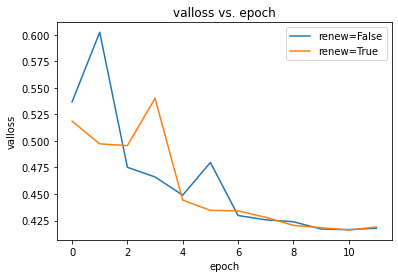

In [37]:
import matplotlib.pyplot as plt
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_1=FeelingCatcher(128,3,renew=False,length_change=True,who='output').to(device)
model_2=FeelingCatcher(128,3,renew=True,length_change=True,who='output').to(device)

history_train_1,history_val_1=fit(12,0.001,model_1,train_loader,val_loader,device=device)
history_train_2,history_val_2=fit(12,0.001,model_2,train_loader,val_loader,device=device)


plt.plot(history_val_1)
plt.plot(history_val_2)
plt.legend(['renew=False','renew=True'])
plt.xlabel('epoch')
plt.ylabel('valloss')
plt.title('valloss vs. epoch')

Epoch [0], train_loss: 0.7168, val_loss: 0.5109, val_acc: 0.7543
Epoch [1], train_loss: 0.4298, val_loss: 0.5090, val_acc: 0.7477
Epoch [2], train_loss: 0.4295, val_loss: 0.5093, val_acc: 0.7507
Epoch [3], train_loss: 0.4430, val_loss: 0.4552, val_acc: 0.7890
Epoch [4], train_loss: 0.5836, val_loss: 0.4524, val_acc: 0.7913
Epoch [5], train_loss: 0.6910, val_loss: 0.4610, val_acc: 0.7840
Epoch [6], train_loss: 0.3923, val_loss: 0.4891, val_acc: 0.7863
Epoch [7], train_loss: 0.3031, val_loss: 0.4258, val_acc: 0.8043
Epoch [8], train_loss: 0.4046, val_loss: 0.4330, val_acc: 0.8095
Epoch [9], train_loss: 0.3202, val_loss: 0.4189, val_acc: 0.8115
Epoch [10], train_loss: 0.4432, val_loss: 0.4150, val_acc: 0.8138
Epoch [11], train_loss: 0.2990, val_loss: 0.4151, val_acc: 0.8131
Epoch [0], train_loss: 0.4368, val_loss: 0.5395, val_acc: 0.7322
Epoch [1], train_loss: 0.4607, val_loss: 0.4989, val_acc: 0.7575
Epoch [2], train_loss: 0.5301, val_loss: 0.4869, val_acc: 0.7703
Epoch [3], train_loss: 

Text(0.5, 1.0, 'valloss vs. epoch')

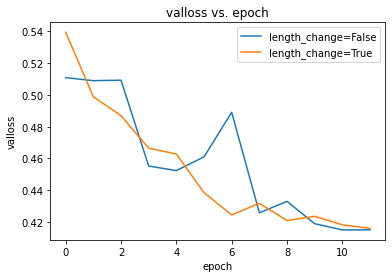

In [38]:
model_1=FeelingCatcher(128,3,renew=False,length_change=False,who='output').to(device)
model_2=FeelingCatcher(128,3,renew=False,length_change=True,who='output').to(device)

history_train_1,history_val_1=fit(12,0.001,model_1,train_loader,val_loader,device=device)
history_train_2,history_val_2=fit(12,0.001,model_2,train_loader,val_loader,device=device)

plt.plot(history_val_1)
plt.plot(history_val_2)
plt.legend(['length_change=False','length_change=True'])
plt.xlabel('epoch')
plt.ylabel('valloss')
plt.title('valloss vs. epoch')

Epoch [0], train_loss: 0.5085, val_loss: 0.5281, val_acc: 0.7392
Epoch [1], train_loss: 0.5670, val_loss: 0.5085, val_acc: 0.7556
Epoch [2], train_loss: 0.4904, val_loss: 0.4773, val_acc: 0.7726
Epoch [3], train_loss: 0.4631, val_loss: 0.4802, val_acc: 0.7734
Epoch [4], train_loss: 0.3372, val_loss: 0.4559, val_acc: 0.7907
Epoch [5], train_loss: 0.6674, val_loss: 0.4497, val_acc: 0.7941
Epoch [6], train_loss: 0.5103, val_loss: 0.4423, val_acc: 0.8022
Epoch [7], train_loss: 0.4925, val_loss: 0.4330, val_acc: 0.8044
Epoch [8], train_loss: 0.5161, val_loss: 0.4286, val_acc: 0.8083
Epoch [9], train_loss: 0.2414, val_loss: 0.4235, val_acc: 0.8110
Epoch [10], train_loss: 0.4038, val_loss: 0.4212, val_acc: 0.8115
Epoch [11], train_loss: 0.3766, val_loss: 0.4223, val_acc: 0.8094
Epoch [0], train_loss: 0.6901, val_loss: 0.6936, val_acc: 0.5006
Epoch [1], train_loss: 0.6931, val_loss: 0.6932, val_acc: 0.5000
Epoch [2], train_loss: 0.6970, val_loss: 0.6943, val_acc: 0.5005
Epoch [3], train_loss: 

Text(0.5, 1.0, 'valloss vs. epoch')

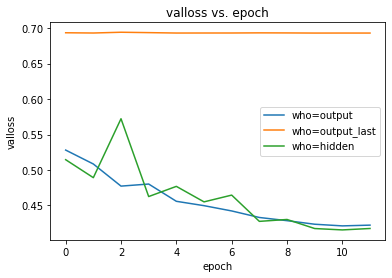

In [39]:
model_1=FeelingCatcher(128,3,renew=True,length_change=True,who='output').to(device)
model_2=FeelingCatcher(128,3,renew=True,length_change=True,who='output_last').to(device)
model_3=FeelingCatcher(128,3,renew=True,length_change=True,who='hidden').to(device)

history_train_1,history_val_1=fit(12,0.001,model_1,train_loader,val_loader,device=device)
history_train_2,history_val_2=fit(12,0.001,model_2,train_loader,val_loader,device=device)
history_train_3,history_val_3=fit(12,0.001,model_3,train_loader,val_loader,device=device)

plt.plot(history_val_1)
plt.plot(history_val_2)
plt.plot(history_val_3)
plt.legend(['who=output','who=output_last','who=hidden'])
plt.xlabel('epoch')
plt.ylabel('valloss')
plt.title('valloss vs. epoch')

In [47]:
def eva_test(confuse):
    #（0，0）：TN，（0，1）：pred=0，label=1 FN
    #（1，0）：pred=1，label=0，FP，（1，1）：TP
    TP=confuse[1,1]
    TN=confuse[0,0]
    FP=confuse[1,0]
    FN=confuse[0,1]
    precise=TP/(FP+TP)
    recall=TP/(TP+FN)
    F1=2*precise*recall/(precise+recall)
    acc=(TP+TN)/(TN+TP+FN+FP)
    return precise,recall,F1,acc

loss,confuse_matrix=test(model_1,test_loader)
precise,recall,F1,acc=eva_test(confuse_matrix)
print('精确率：',acc,'\n',' 准确率:',precise,'\n','召回率:',recall,'\n','F1分数:',F1)

精确率： 0.8346883468834688 
  准确率: 0.8705882352941177 
 召回率: 0.7914438502673797 
 F1分数: 0.8291316526610645


In [ ]:
import jieba

def predict(x,path='comment.pth'):
    comment=x.split('，')
    seg=[' '.join(jieba.cut(i,cut_all=False)) for i in comment]
    num_seg=[]
    for i in seg:
        j=i.split(' ')
        for l in j:
            try:
                num_seg.append(word2ix[l])
            except KeyError:
                num_seg.append(0)
    num_seg=torch.tensor(num_seg)
    num_seg=num_seg.unsqueeze(0)
    seg_len=[num_seg.size()[1]]

    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=FeelingCatcher(128,3,renew=True,length_change=True,who='output_last').to(device)
    model.load_state_dict(torch.load(path,map_location='cpu'))

    pred=torch.argmax(model(num_seg,seg_len))
    if pred:
        print(x,'\n','是差评55555')
    else:
        print(x,'\n','是好评！')

In [ ]:
predict('整部片子全是变态。一个不良少女，一个弱智杀手，一个丧心病狂的警察。我怎么会看这么毁三观的片子。')
print('------------------------------------------------------------------------')
predict('里昂只有一颗盆栽，不善言辞，爱喝牛奶。他不像，却真正是一个杀手。玛蒂达的到来，是包袱，也给里昂带来了生机。不过这种设定，注定是悲剧收场。里昂死后，玛蒂达将他盆栽的种子落地生根，里昂终于不再每日拿着手枪在椅子上不安地入睡，他落地了。娜塔莉波特曼太灵了，玛蒂达是如此特别。')